<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/CSHA-summer-course/tutorials/Computational%20Neuroscience/neuro_model/2_3_reduced_neuron_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reduced Neuron Models

In [1]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 7.3 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=7f2a5a254298fa299277e686d3bba4b2c2c7c5509b11adf11285776ca95f85f6
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [2]:
import brainpy as bp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
bp.backend.set('numba', dt=0.01)

## HH model reduction

### Original model

$$
\begin{aligned}
C \frac{dV}{dt} &= -(\bar{g}_{Na} m^3 h (V - E_{Na}) + \bar{g}_K n^4(V - E_K) + g_{leak}(V - E_{leak})) + I(t) \\
\frac{dx}{dt} &= \alpha_x(1-x) - \beta_x , x \in \{ m, h, n \} \\
\alpha_m(V) &= \frac{0.1(V+40)}{1 - exp(\frac{-(V+40)}{10})} \\
\beta_m(V) &= 4.0 exp(\frac{-(V+65)}{18}) \\
\alpha_h(V) &= 0.07 exp(\frac{-(V+65)}{20}) \\
\beta_h(V) &= \frac{1}{1 + exp(\frac{-(V + 35)}{10})} \\
\alpha_n(V) &= \frac{0.01(V+55)}{1 - exp(\frac{-(V+55)}{10})} \\
\beta_n(V) &= 0.125 exp(\frac{-(V+65)}{80}) 
\end{aligned}
$$

where $E_{Na}=50.\, mV$, $g_{Na}=120.\, mS/cm^2$, $E_K=-77.\, mV$, $g_K=36.\, mS/cm^2$, $E_L=-54.387\, mV$, $g_L=0.03\, mS/cm^2$, $V_{th}=20.\, mV$, $C=1.0 \, \mu F /cm^2$.

In [4]:
class HH(bp.NeuGroup):
  """Hodgkin–Huxley neuron model."""

  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387,
               gL=0.03, V_th=20., C=1.0, **kwargs):
    super(HH, self).__init__(size=size, **kwargs)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th
    self.C = C

    # variables
    self.V = -65. * np.ones(self.num)
    self.m = 0.5 * np.ones(self.num)
    self.h = 0.6 * np.ones(self.num)
    self.n = 0.32 * np.ones(self.num)
    self.input = np.zeros(self.num)
    self.spike = np.zeros(self.num, dtype=bool)
    self.t_last_spike = np.ones(self.num) * -1e7

  def update(self, _t):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n,
                               _t, self.C, self.gNa, self.ENa, self.gK,
                               self.EK, self.gL, self.EL, self.input)
    spike = (self.V < self.V_th) and (V >= self.V_th)
    self.spike = spike
    self.t_last_spike = np.where(spike, _t, self.t_last_spike)
    self.V = V
    self.m = m
    self.h = h
    self.n = n
    self.input[:] = 0.

In [5]:
hh = HH(1, monitors=['V', 'm', 'h', 'n'])

hh.run(100., inputs=('input', 10.), report=True)

Compilation used 5.1605 s.
Start running ...
Run 10.0% used 0.027 s.
Run 20.0% used 0.054 s.
Run 30.0% used 0.082 s.
Run 40.0% used 0.110 s.
Run 50.0% used 0.137 s.
Run 60.0% used 0.161 s.
Run 70.0% used 0.186 s.
Run 80.0% used 0.215 s.
Run 90.0% used 0.246 s.
Run 100.0% used 0.271 s.
Simulation is done in 0.272 s.



0.27152156829833984

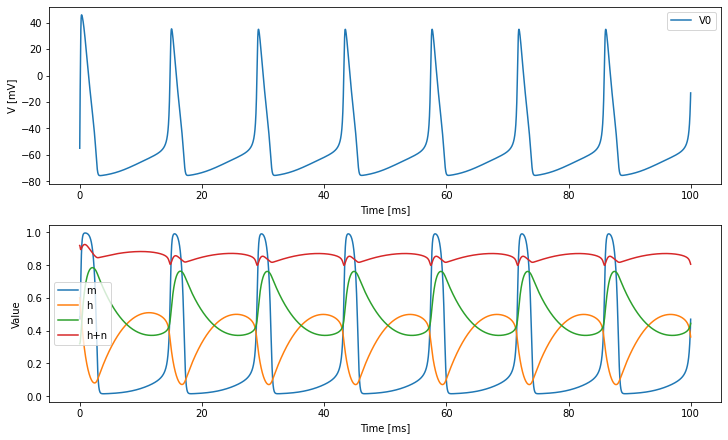

In [6]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 10)

fig.add_subplot(gs[0, 0])
plt.plot(hh.mon.ts, hh.mon.V[:, 0], label='V0')
plt.xlabel('Time [ms]')
plt.ylabel('V [mV]')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(hh.mon.ts, hh.mon.m[:, 0], label='m')
plt.plot(hh.mon.ts, hh.mon.h[:, 0], label='h')
plt.plot(hh.mon.ts, hh.mon.n[:, 0], label='n')
plt.plot(hh.mon.ts,  hh.mon.h[:, 0] + hh.mon.n[:, 0], label='h+n')
plt.xlabel('Time [ms]')
plt.ylabel('Value')
plt.legend()

plt.show()

In [ ]:
(hh.mon.h[:, 0] + hh.mon.n[:, 0]).mean()

0.854669921741234

### Reduced model

Here, we assume $m$ behaves instantaneously, and $m = m_{\infty}(V) = \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)}$. Moreover, $h$ and $n$ have the relation of $h + n = 0.855$.


$$
\begin{aligned}
C \frac{dV}{dt} &= -(\bar{g}_{Na} m_{\infty}^3 h (V - E_{Na}) + \bar{g}_K (0.855 - h)^4(V - E_K) + g_{leak}(V - E_{leak})) + I(t) \\
\frac{dh}{dt} &= \alpha_h(1-h) - \beta_h \\
m_{\infty} &= \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)} \\
\alpha_m(V) &= \frac{0.1(V+40)}{1 - \exp(\frac{-(V+40)}{10})} \\
\beta_m(V) &= 4.0 \exp(\frac{-(V+65)}{18}) \\
\alpha_h(V) &= 0.07 \exp(\frac{-(V+65)}{20}) \\
\beta_h(V) &= \frac{1}{1 + \exp(\frac{-(V + 35)}{10})} 
\end{aligned}
$$

where $E_{Na}=50.\, mV$, $g_{Na}=100.\, mS/cm^2$, $E_K=-77.\, mV$, $g_K=36.\, mS/cm^2$, $E_L=-75\, mV$, $g_L=0.05\, mS/cm^2$, $V_{th}=20.\, mV$, $C=1.0 \, \mu F /cm^2$.

In [7]:
class ReducedHH(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='rk4')
  def integral(V, h, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    m_inf = alpha / (alpha + beta)
    
    I_Na = (gNa * m_inf ** 3.0 * h) * (V - ENa)
    I_K = (gK * (0.855 - h) ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dhdt

  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387,
               gL=0.03, V_th=20., C=1.0, **kwargs):
    super(ReducedHH, self).__init__(size=size, **kwargs)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th
    self.C = C

    # variables
    self.V = -65. * np.ones(self.num)
    self.h = 0.6 * np.ones(self.num)
    self.input = np.zeros(self.num)
    self.spike = np.zeros(self.num, dtype=bool)
    self.t_last_spike = np.ones(self.num) * -1e7

  def update(self, _t):
    V, h = self.integral(self.V, self.h, _t, self.C, self.gNa, self.ENa, 
                         self.gK, self.EK, self.gL, self.EL, self.input)
    spike = (self.V < self.V_th) and (V >= self.V_th)
    self.spike = spike
    self.t_last_spike = np.where(spike, _t, self.t_last_spike)
    self.V = V
    self.h = h
    self.input[:] = 0.

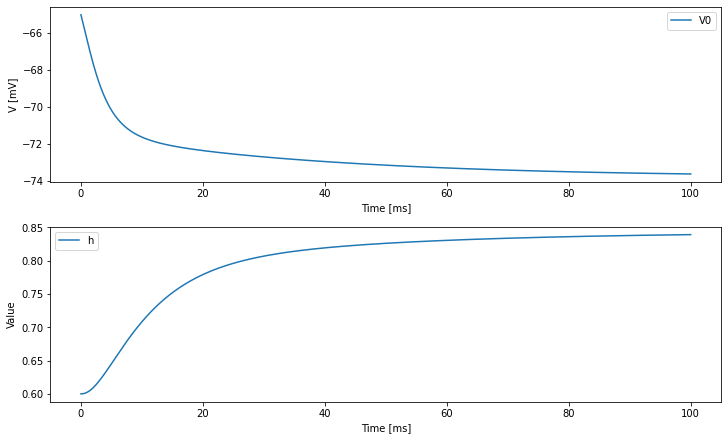

In [8]:
hh2 = ReducedHH(1, gNa=100, gL=0.05, EL=-75, monitors=['V', 'h'])

hh2.run(100., inputs=('input', 0.))

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)

fig.add_subplot(gs[0, 0])
plt.plot(hh2.mon.ts, hh2.mon.V[:, 0], label='V0')
plt.xlabel('Time [ms]')
plt.ylabel('V [mV]')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(hh2.mon.ts, hh2.mon.h[:, 0], label='h')
plt.xlabel('Time [ms]')
plt.ylabel('Value')
plt.legend()

plt.show()

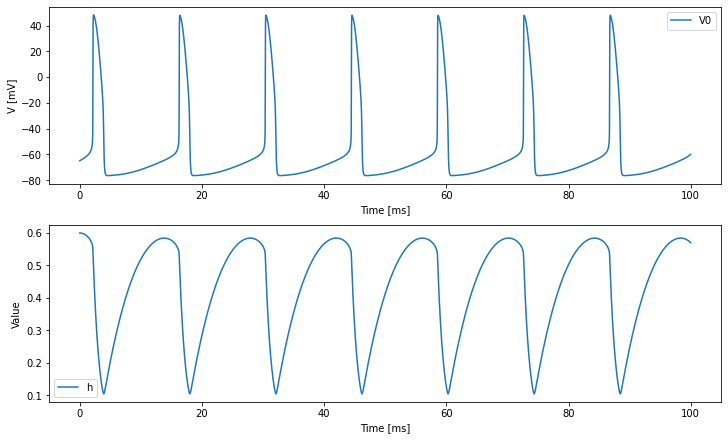

In [9]:
hh2 = ReducedHH(1, gNa=100, gL=0.05, EL=-75, monitors=['V', 'h'])

hh2.run(100., inputs=('input', 4.))

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)

fig.add_subplot(gs[0, 0])
plt.plot(hh2.mon.ts, hh2.mon.V[:, 0], label='V0')
plt.xlabel('Time [ms]')
plt.ylabel('V [mV]')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(hh2.mon.ts, hh2.mon.h[:, 0], label='h')
plt.xlabel('Time [ms]')
plt.ylabel('Value')
plt.legend()

plt.show()

### Phase plane analysis

In [10]:
from collections import OrderedDict

$I_{ext}$ = 4.

plot nullcline ...
SymPy solve "integral(V, h) = 0" to "h = f(V, )", success.
SymPy solve "integral(V, h) = 0" to "h = f(V, )", failed because 5 s timeout.
SymPy solve "integral(V, h) = 0" to "V = f(h)", failed because 5 s timeout.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
Fixed point #1 at V=-63.33460360845656, h=0.536951306807153 is a unstable focus.


(array([-63.33460361]), array([0.53695131]))

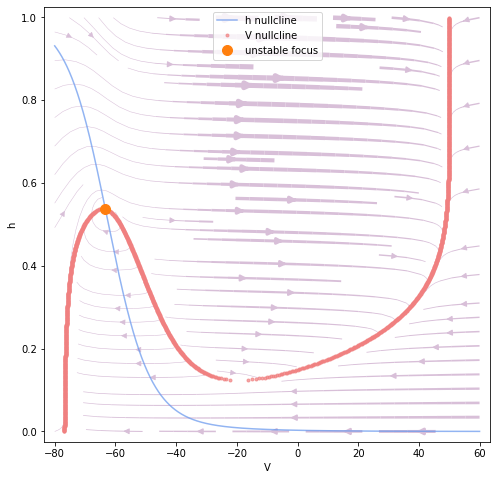

In [19]:
analyzer = bp.analysis.PhasePlane(
    integrals=hh2.integral,
    target_vars=OrderedDict(V=[-80, 60], h=[0., 1.],),
    pars_update=dict(C=1., gNa=100., ENa=50., gK=36., EK=-77., gL=0.05, EL=-75, Iext=4.),
    numerical_resolution={'V': 0.1, 'h': 0.001},
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
# analyzer.plot_trajectory([{'V': -65., 'h': 0.}], duration=100., show=True)

$I_{ext}$ = 0.2

plot nullcline ...
SymPy solve "integral(V, h) = 0" to "h = f(V, )", success.
SymPy solve "integral(V, h) = 0" to "h = f(V, )", failed because 5 s timeout.
SymPy solve "integral(V, h) = 0" to "V = f(h)", failed because 5 s timeout.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
Fixed point #1 at V=-67.57536700707126, h=0.6823962756117151 is a stable focus.


(array([-67.57536701]), array([0.68239628]))

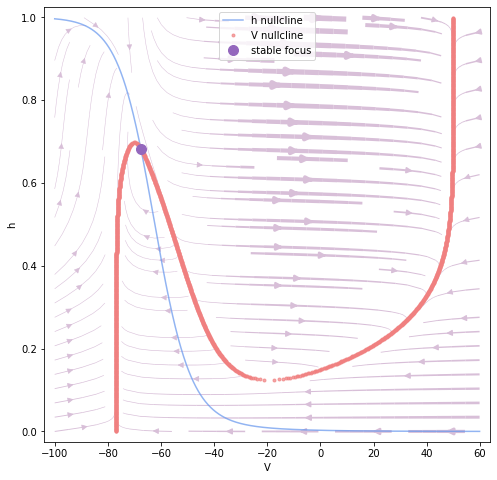

In [20]:
analyzer = bp.analysis.PhasePlane(
    integrals=hh2.integral,
    target_vars=OrderedDict(V=[-100, 60], h=[0., 1.], ),
    pars_update=dict(C=1., gNa=100., ENa=50., gK=36., EK=-77., gL=0.05, EL=-75, Iext=0.2),
    numerical_resolution={'V': 0.1, 'h': 0.001},
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
# analyzer.plot_trajectory([{'V': -65., 'h': 0.}, {'V': -20., 'h': 0.6}],duration=100.,show=True)

$I_{ext}$ = 10.

plot nullcline ...
SymPy solve "integral(V, h) = 0" to "h = f(V, )", success.
SymPy solve "integral(V, h) = 0" to "h = f(V, )", failed because 5 s timeout.
SymPy solve "integral(V, h) = 0" to "V = f(h)", failed because 5 s timeout.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
SymPy solve derivative of "integral(V, h)" by "V", success.
SymPy solve derivative of "integral(V, h)" by "h", success.
Fixed point #1 at V=-61.5406167711182, h=0.4724858311595149 is a stable focus.


(array([-61.54061677]), array([0.47248583]))

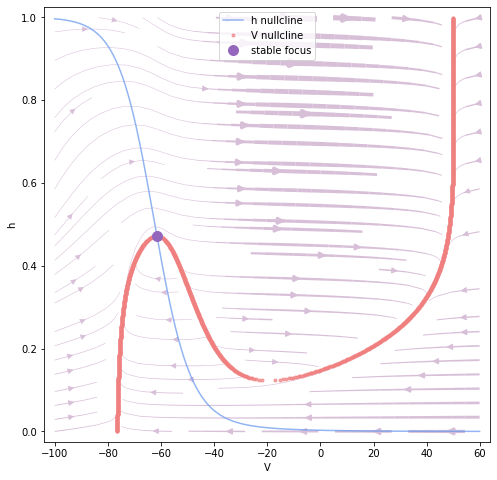

In [21]:
analyzer = bp.analysis.PhasePlane(
    integrals=hh2.integral,
    target_vars=OrderedDict(V=[-100, 60], h=[0., 1.], ),
    pars_update=dict(C=1., gNa=100., ENa=50., gK=36., EK=-77., gL=0.05, EL=-75, Iext=10.),
    numerical_resolution={'V': 0.1, 'h': 0.001},
)
plt.figure(figsize=(8, 8))
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
# analyzer.plot_trajectory([{'V': -61.5406, 'h': 0.45}, {'V': -20., 'h': 0.6}],duration=100.,show=True)

## LIF model

The most typical reduced model is the Leaky Integrate-and-Fire model (LIF model) presented by Lapicque (1907). LIF model can be seen as a combination of integrate process represented by differential equation and spike process represented by conditional judgment:

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + R I(t)$$

If  $V > V_{th}$, neuron fire, 

$$ V \gets V_{reset} \,\, \mathrm{and} \, \mathrm{last} \, \tau_{ref} \, \mathrm{ms} $$.

where $V$ is the membrane potential, $V_{rest}=0$ mV is the rest membrane potential, $V_{th}=20$ mV is the spike threshold, $\tau=10$ ms is the time constant, $\tau_{ref}=1.$ ms is the refractory time period, $R=1.$ is the resistance, and $I=21.$ mA is the synaptic inputs.

In [31]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size, t_ref=1., V_rest=0., V_reset=0.,
               V_th=20., R=1., tau=10., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * V_rest
    self.input = bp.ops.zeros(self.num)
    
  @staticmethod
  @bp.odeint
  def integral(V, t, Iext, V_rest, R, tau):
    dVdt = (- (V - V_rest) + R * Iext) / tau
    return dVdt

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.


In [39]:
lif = LIF(1, t_ref=10., monitors=['V'])
lif.run(200, inputs=('input', 21), report=True)

Compilation used 0.2997 s.
Start running ...
Run 10.0% used 0.027 s.
Run 20.0% used 0.056 s.
Run 30.0% used 0.083 s.
Run 40.0% used 0.109 s.
Run 50.0% used 0.143 s.
Run 60.0% used 0.167 s.
Run 70.0% used 0.193 s.
Run 80.0% used 0.241 s.
Run 90.0% used 0.269 s.
Run 100.0% used 0.290 s.
Simulation is done in 0.290 s.



0.2903163433074951

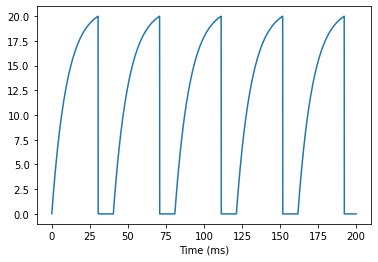

In [40]:
bp.visualize.line_plot(lif.mon.ts, lif.mon.V)

**F-I curve**

Compilation used 0.2870 s.
Start running ...
Run 10.0% used 0.094 s.
Run 20.0% used 0.187 s.
Run 30.0% used 0.284 s.
Run 40.0% used 0.382 s.
Run 50.0% used 0.474 s.
Run 60.0% used 0.579 s.
Run 70.0% used 0.669 s.
Run 80.0% used 0.764 s.
Run 90.0% used 0.861 s.
Run 100.0% used 0.956 s.
Simulation is done in 0.956 s.



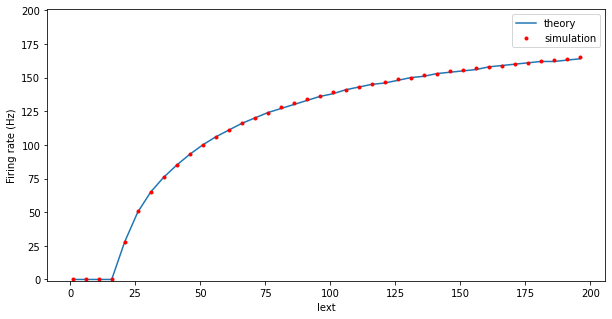

In [34]:
t_ref = 5.
V_rest = 0.
V_reset = 0.
V_th = 20.
tau = 10.
R = 1.

Iext = np.arange(1, 200, 5)
neu = LIF(len(Iext), t_ref=t_ref, V_rest=V_rest, V_reset=V_reset, V_th=V_th,
          R=R, tau=tau, monitors=['spike'])
neu.run(1000., inputs=('input', Iext), report=True)

rate_by_sim = neu.mon.spike.sum(axis=0)
valid_idx = np.where((1. - (V_th - V_reset) / (R * Iext)) > 0.)[0]
rate_by_theory = np.zeros_like(Iext)
rate_by_theory[valid_idx] = 1000. / (t_ref - tau * np.log(1. - (V_th - V_reset) / (R * Iext[valid_idx])))

plt.figure(figsize=(10, 5))
plt.plot(Iext, rate_by_theory, label="theory")
plt.plot(Iext, rate_by_sim, 'r.', label="simulation")
plt.legend()
plt.xlabel('Iext')
plt.ylabel('Firing rate (Hz)')
plt.ylim(-1, 1e3 / t_ref + 1.)
plt.show()

## Exponential LIF

Exponential Integrate-and-Fire model (ExpIF model) (Fourcaud-Trocme et al., 2003) is more expressive than QuaIF model.

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} + R I(t)$$

If  $V > V_{th}$, neuron fire, 

$$ V \gets V_{reset} \,\, \mathrm{and} \, \mathrm{last} \, \tau_{ref} \, \mathrm{ms} $$.

where
- $\Delta_T = 3.48$, 
- $\tau = 10.$ ms, 
- $V_{rest}=-65.$ mV, 
- $V_{reset}=-68.$ mV, 
- $V_T=-59.9$ mV, 
- $V_th=-30.$ mV, 
- $\tau_{ref}=1.7$ ms, 
- $R=10.$

In [45]:
class ExpIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size, V_rest=-65., V_reset=-68.,
               V_th=-30., V_T=-59.9, delta_T=3.48,
               R=10., tau=10., t_refractory=1.7,
               **kwargs):
    super(ExpIF, self).__init__(size=size, **kwargs)

    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.R = R
    self.tau = tau
    self.t_refractory = t_refractory

    # variables
    self.V = np.ones(self.num) * V_rest
    self.input = np.zeros(self.num)
    self.spike = np.zeros(self.num, dtype=bool)
    self.refractory = np.zeros(self.num, dtype=bool)
    self.t_last_spike = np.ones(self.num) * -1e7

  @staticmethod
  @bp.odeint
  def integral(V, t, Iext, V_rest, R, tau, delta_T, V_T):
    dVdt = (- (V - V_rest) + delta_T * bp.ops.exp((V-V_T)/delta_T) + R * Iext) / tau
    return dVdt

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_refractory
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau, self.delta_T, self.V_T)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
      self.input[i] = 0.


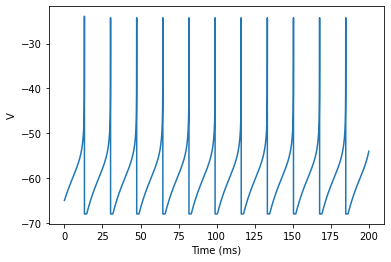

In [50]:
neu = ExpIF(100, t_refractory=1.5, V_th=20., monitors=['V', 'spike'])
neu.run(duration=200., inputs=('input', 1.))

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, ylabel="V", show=True)

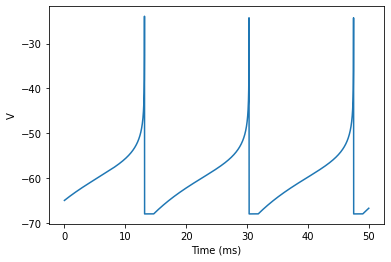

In [51]:
neu = ExpIF(100, t_refractory=1.5, V_th=20., monitors=['V', 'spike'])
neu.run(duration=50., inputs=('input', 1.))

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, ylabel="V", show=True)

## Adaptive ExIF

To reproduce the adaptation behavior of neurons, researchers add a weight variable $w% to existing integrate-and-fire models like LIF, QuaIF and ExpIF models. Here we introduce a typical one: **Adaptative Exponential Integrate-and-Fire model (AdExIF model)**.

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} - R w + R I(t)$$
$$ \tau_w \frac{dw}{dt} = a(V - V_{rest})- w + b \tau_w \sum \delta(t - t^f))$$

If  $V > V_{th}$, neuron fire, 

$$ V \gets V_{reset} \,\, \mathrm{and} \, \mathrm{last} \, \tau_{ref} \, \mathrm{ms} $$.


Facing a constant input, the firing rate of AdExIF neuron decreases over time. These adaptation is controlled by the weight variable $w$.

- $V_{rest}= -65.$ mV is the resting potential, 
- $V_{reset}=-68.$ mV is the reset potential after spike, 
- $V_{th}= -30.$ mV is the threshold potential of spike and reset, 
- $V_T=-59.9$ mV is threshold potential of generating action potential,
- $\Delta_T = 3.48$ is the spike slope factor, 
- $a=1$ is the sensitivity of the recovery variable $w$ to the sub-threshold fluctuations of the membrane potential $V$, 
- $b=1$ is the increment of $w$ produced by a spike, 
- $R=1$  is the membrane resistance, 
- $\tau= 10$ ms is the membrane time constant, 
- $\tau_w= 30$ ms is the time constant of the adaptation current, 
- $\tau_{ref}=0.$ ms is the refractory period length.

In [ ]:
bp.backend.set('numba', dt=0.001)

In [ ]:
class AdExIF(bp.NeuGroup):
  target_backend = 'general'

  def __init__(self, size, V_rest=-65., V_reset=-68.,
               V_th=-30., V_T=-59.9, delta_T=3.48,
               a=1., b=1., R=10., tau=10., tau_w=30.,
               t_refractory=0., **kwargs):
    super(AdExIF, self).__init__(size=size, **kwargs)

    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.a = a
    self.b = b
    self.R = R
    self.tau = tau
    self.tau_w = tau_w
    self.t_refractory = t_refractory

    # variables
    self.V = bp.ops.ones(self.num) * V_reset
    self.w = bp.ops.zeros(self.num)
    self.input = bp.ops.zeros(self.num)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.t_last_spike = bp.ops.ones(self.num) * -1e7

  @staticmethod
  @bp.odeint
  def integral(V, w, t, Iext, V_rest, R, ,delta_T, V_T, tau, tau_w, a, b):
    dVdt = (- (V - V_rest) + delta_T * bp.ops.exp((V-V_T)/delta_T) + R * Iext - R * w) / tau
    dwdt = (a(V - V_rest) - w + b*tau_w)
    return dVdt

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_refractory
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau, self.delta_T, self.V_T)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          
          self.t_last_spike[i] = _t
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
      self.input[i] = 0.

Compilation used 0.5890 s.
Start running ...
Run 10.0% used 0.246 s.
Run 20.0% used 0.477 s.
Run 30.0% used 0.717 s.
Run 40.0% used 0.947 s.
Run 50.0% used 1.186 s.
Run 60.0% used 1.440 s.
Run 70.0% used 1.661 s.
Run 80.0% used 1.892 s.
Run 90.0% used 2.119 s.
Run 100.0% used 2.356 s.
Simulation is done in 2.356 s.



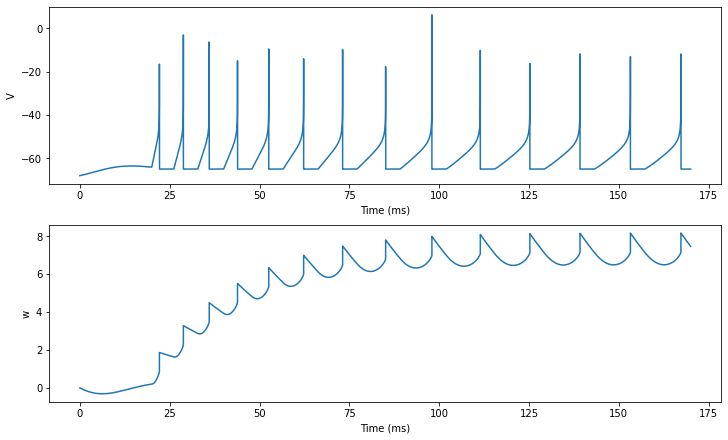

In [ ]:
neu = AdExIF(100, t_refractory=4., V_th=20., monitors=['V', 'w'])

Iex, duration = bp.inputs.constant_input([(0, 20), (8, 150)])
neu.run(duration, inputs=('input', Iex), report=True)

fig, gs = bp.visualize.get_figure(2, 1, 3, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V, ylabel="V")
fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.w, ylabel="w")